## ALGYAN Community 2022.09.26. 月曜日
### エッジAI入門＆活用シリーズ#2 『ONNXモデル』 編
### ONNXモデルと既存ディープラーニングモデルとの性能比較 : Tensorflow vs ONNX - 全美貞(Mijeong Jeon)

### コンテンツ一覧
1. パッケージのインストール
2. MNIST Tensorflow モデルのトレーニング
3. TF を変換 -> ONNX
4. TF と ONNX のパフォーマンスの比較 1. 精度
5. TF と ONNX のパフォーマンスの比較 2. 速度

### Dependency 
* Python 3.8
* Tensorflow 2.9.1
* tf2onnx 1.12.1
* onnx 1.12.0
* onnxruntime 1.12.1


In [ ]:
# 1. tf2onnx(tf -> onnx) パッケージをインストール

!pip install tf2onnx

In [2]:
# 2. MNIST Tensorflow モデルのトレーニング

import tensorflow as tf

# MNIST データセットの読み込み
(train_X, train_y), (test_X, test_y) = tf.keras.datasets.mnist.load_data()
train_X, test_X = train_X/255.0, test_X/255.0

# CNN モデル ネットワーク
tf_model = tf.keras.Sequential(
    [
        tf.keras.layers.Conv2D(16, kernel_size=(3, 3), activation='relu', input_shape=(28, 28, 1)),
        tf.keras.layers.MaxPooling2D(pool_size=(2, 2)),
        tf.keras.layers.Conv2D(32, kernel_size=(3, 3), activation='relu'),
        tf.keras.layers.MaxPooling2D(pool_size=(2, 2)),
        tf.keras.layers.Conv2D(32, kernel_size=(3, 3), activation='relu'),
        tf.keras.layers.Flatten(),
        tf.keras.layers.Dense(64, activation='relu'),
        tf.keras.layers.Dense(10, activation='softmax')
    ]
)

# モデルコンパイル
tf_model.compile(
    loss='sparse_categorical_crossentropy',
    optimizer='adam',
    metrics=['accuracy']
) 

# 訓練モデル
tf_model.fit(train_X, train_y)

# トレーニング済み TF モデルの保存
tf_model.save('tf_model', include_optimizer=False)

2022-09-23 06:19:09.368697: E tensorflow/stream_executor/cuda/cuda_driver.cc:271] failed call to cuInit: CUDA_ERROR_NO_DEVICE: no CUDA-capable device is detected
2022-09-23 06:19:09.368774: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (computer-cpu): /proc/driver/nvidia/version does not exist
2022-09-23 06:19:09.369548: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


1875/1875 [==============================] - 14s 7ms/step - loss: 0.1848 - accuracy: 0.9438
INFO:tensorflow:Assets written to: tf_model/assets


In [3]:
# 3. TF モデルを ONNX モデルに変換する

!python -m tf2onnx.convert --saved-model tf_model --output onnx_model.onnx --opset 15

/anaconda/envs/azureml_py38/lib/python3.8/runpy.py:127: RuntimeWarning: 'tf2onnx.convert' found in sys.modules after import of package 'tf2onnx', but prior to execution of 'tf2onnx.convert'; this may result in unpredictable behaviour
  warn(RuntimeWarning(msg))
2022-09-23 06:20:32,535 - WARNING - '--tag' not specified for saved_model. Using --tag serve
2022-09-23 06:20:33,080 - INFO - Signatures found in model: [serving_default].
2022-09-23 06:20:33,080 - WARNING - '--signature_def' not specified, using first signature: serving_default
2022-09-23 06:20:33,081 - INFO - Output names: ['dense_1']
Instructions for updating:
Use `tf.compat.v1.graph_util.extract_sub_graph`
2022-09-23 06:20:33,269 - WARNING - From /anaconda/envs/azureml_py38/lib/python3.8/site-packages/tf2onnx/tf_loader.py:715: extract_sub_graph (from tensorflow.python.framework.graph_util_impl) is deprecated and will be removed in a future version.
Instructions for updating:
Use `tf.compat.v1.graph_util.extract_sub_graph`
20

In [4]:
# 4. TF モデルと ONNX モデル : 精度の予測

import onnxruntime
from sklearn.metrics import accuracy_score
import numpy as np

onnx_model = onnxruntime.InferenceSession('onnx_model.onnx', providers=['CPUExecutionProvider'])

test_X = test_X.reshape(-1,28,28,1).astype('float32')

tf_result = tf_model(test_X)
onnx_result = onnx_model.run(None,{onnx_model.get_inputs()[0].name: test_X})[0]

print("tf result: ", accuracy_score(np.argmax(tf_result, axis=1), test_y))
print("onnx result: ", accuracy_score(np.argmax(onnx_result, axis=1), test_y))

tf result:  0.9813
onnx result:  0.9813


In [6]:
# 5. TF モデルと ONNX モデル: 推論速度

import time

# Tensorflow Time
tf_start = time.time()
tf_model(test_X)
tf_time = time.time() - tf_start
print("tf running time: ", tf_time)

# ONNX Time
onnx_start = time.time()
onnx_model.run(None,{
            onnx_model.get_inputs()[0].name: test_X
        })
onnx_time = time.time() - onnx_start
print("onnx running time: ", onnx_time)

tf running time:  0.3586733341217041
onnx running time:  0.15854907035827637


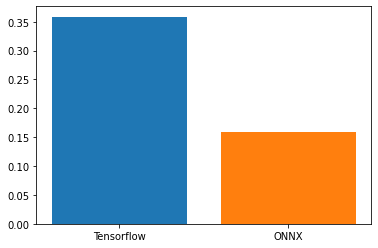

In [7]:
import matplotlib.pyplot as plt

plt.figure()

frameworks = ["Tensorflow", "ONNX"]
times = [tf_time, onnx_time]

plt.bar(frameworks[0], times[0])
plt.bar(frameworks[1], times[1])
plt.show()
